In [0]:
def kaggle_function():
  
  print('Please make sure you have downloaded a kaggle .jason token and its somewhere on your local machine')
  print('\n Let us first of all import the json token to Google Colab here')
  
  #first let's import the json file into the working directory
  import json
  from google.colab import files
  files.upload()
  
  
  print('\n Alright sit back and let me handle the rest for you')
  
  #now that we have imported the kaggle json file let us make the directory needed to keep the json file
  !mkdir -p ~/.kaggle
  
  #let's copy the file there to the kaggle folder
  !cp kaggle.json ~/.kaggle/
  
  #let us encrypt the file so that we don't get hacked
  !chmod 600 ~/.kaggle/kaggle.json
  
  #now let's install kaggle packages
  !pip install kaggle
  
  print("Success! Here is the Kaggle Competitions List to show this works")
  
  #let's do a simple listing of the files that kaggle has
  !kaggle competitions list
  
  print('\n\nWhat you need to do now is: go to the competition whose data you need and copy the download code and paste it in the next cell')

In [2]:
kaggle_function()

Please make sure you have downloaded a kaggle .jason token and its somewhere on your local machine

 Let us first of all import the json token to Google Colab here


Saving kaggle.json to kaggle.json

 Alright sit back and let me handle the rest for you
Success! Here is the Kaggle Competitions List to show this works
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2720           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10942            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4539            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         51           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       41

In [3]:
#let's download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:22<00:00, 67.2MB/s]
100% 1.15G/1.15G [00:22<00:00, 54.2MB/s]


In [0]:
#lets unzip the file
import zipfile

zipfilePath = ("./chest_xray.zip")
zip = zipfile.ZipFile(zipfilePath)
zip.extractall(".")
zip.close()

In [0]:
import os
import sys
import glob
import matplotlib
import numpy as np
matplotlib.use('agg')
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from keras import backend as K
from keras import __version__
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from keras.preprocessing import image
from keras.models import load_model

In [0]:
IM_WIDTH, IM_HEIGHT = 299, 299 
NB_EPOCHS = 5
BAT_SIZE = 32
FC_SIZE = 1024


%matplotlib inline

In [0]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

In [0]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [0]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = Dropout(0.5)(x)
    x = AveragePooling2D((8, 8), border_mode='valid', name='avg_pool')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(input=base_model.input, output=predictions)
    return model

In [12]:
## For best Val ACC found, save the model at that epoch
filepath="Resnet50_weights_3.h5"
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
!rm chest_xray/val/.DS_Store

In [0]:
def train(epochs, output_model_file, plot = True ):
    """Using transfer learning """
    train_img = 'chest_xray/train/' 
    validation_img = 'chest_xray/val/'
    nb_epoch = int(epochs)
    nb_train_samples = get_nb_files(train_img)
    nb_classes = len(glob.glob(train_img + "/*"))
    # data prep
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    validation_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    
    train_generator = train_datagen.flow_from_directory(
			train_img,
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)
    validation_generator = validation_datagen.flow_from_directory(
			validation_img,
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)
    if(K.image_dim_ordering() == 'th'):
        input_tensor = Input(shape=(3, 299, 299))
    else:
        input_tensor = Input(shape=(299, 299, 3))
    
    # setup model
    base_model = InceptionV3(input_tensor = input_tensor,weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
    
    
    history_tl = model.fit_generator(train_generator,
                                   samples_per_epoch=320,
                                   nb_epoch=nb_epoch,
                                   validation_data=validation_generator,
                                   nb_val_samples=64,
                                   callbacks=[lr_reduce,checkpoint]) 
    model.save(output_model_file)
    if plot:
        plot_training(history_tl)

In [0]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('accuracy.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig('loss.png')

In [19]:
train(epochs = 10, output_model_file = 'resnet_new_model.h5')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


AttributeError: ignored

### Validation accuracy achieved ~80%. 

## Predictions on test data

In [0]:
target_size = (299, 299) # for inceptionv3

In [0]:
def predict(model, img, target_size = target_size):
    img = cv2.imread(img)
    img = cv2.resize(img,(299,299))
    x = np.reshape(img,[299,299,3])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [0]:
def plot_preds(image, preds):
    labels = ("NORMAL", "PNEUMONIA")
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probabilities')
    plt.xlim(0,1.01)
    plt.tight_layout()

In [0]:
# Load saved model
model = load_model('weights_3.h5')

### 0: Normal    1: Pneumonia

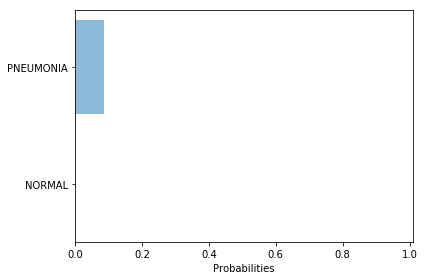

In [0]:
# Pred 1
img =  'test/PNEUMONIA/person48_virus_100.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [0]:
res = np.argmax(preds)
print(res)   

1


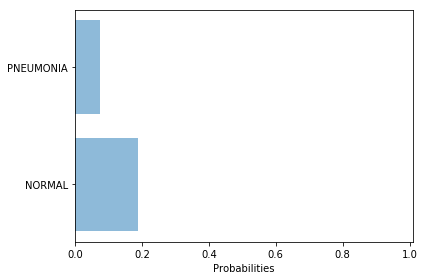

In [0]:
# Pred 2
img =  'test/NORMAL/IM-0105-0001.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [0]:
res = np.argmax(preds)
print(res)   

0


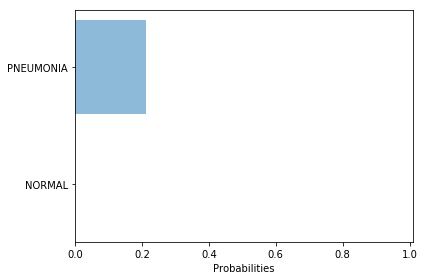

In [0]:
# Pred 3
img =  'test/PNEUMONIA/person1672_virus_2888.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [0]:
res = np.argmax(preds)
print(res)   

1
